# MNIST classifier from scratch

This notebook aims to display how we can easily built a Classifier & train it from scratch.
The notebook is restricted to 3 & 7 Classification (Doesn't go deeper in to multi class classification & usage of softmax).

- Firstly by creating a baseline against which we can compare the classifier
- Then creating a classifier
- Slowly displacing the parts (such as parameters), to a much more generic usage

In [214]:
!pip install -q fastbook

In [215]:
from fastai.vision.all import *
from fastbook import *

In [216]:
path = untar_data(URLs.MNIST_SAMPLE)

In [217]:
path.ls()

(#3) [Path('/root/.fastai/data/mnist_sample/valid'),Path('/root/.fastai/data/mnist_sample/labels.csv'),Path('/root/.fastai/data/mnist_sample/train')]

## Basline function

Baseline function will be created by a mean image (by creating mean of all pixels of a image type, e.g. 7 or 3).

In [218]:
img = Image.open('/root/.fastai/data/mnist_sample/train/7/22753.png')
img

The `img` is a byte stream. We can either use a `array(img)` or `tensor(img)` to get the pixel data.
For our need the `tensor(img)` is the right way (so we can use CUDA calculations).

In [219]:
# Open images and transform them to tensors.
# Then run a cuda average on them
threes = (path/'train/3').ls().sorted()
sevens = (path/'train/7').ls().sorted()

threes_tensors = [tensor(Image.open(image)) for image in threes] 
sevens_tensors = [tensor(Image.open(image)) for image in sevens]

<AxesSubplot: >

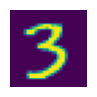

In [220]:
show_image(threes_tensors[1])

In [221]:
threes_merged = torch.stack(threes_tensors).float()/255
sevens_merged = torch.stack(sevens_tensors).float()/255

threes_merged.shape, sevens_merged.shape

(torch.Size([6131, 28, 28]), torch.Size([6265, 28, 28]))

In [222]:
average_three = torch.mean(threes_merged, dim=0)
average_seven = torch.mean(sevens_merged, dim=0)

<AxesSubplot: >

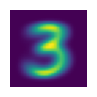

In [223]:
show_image(average_three)

<AxesSubplot: >

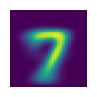

In [224]:
show_image(average_seven)

We already have the mean images for both clases. Now we need to create validation sets that we can use to calculate the loss

In [225]:
valid_threes = (path/'valid/3').ls().sorted()
valid_sevens = (path/'valid/7').ls().sorted()

In [226]:
valid_sevens_loaded = [tensor(Image.open(image)) for image in valid_sevens]
valid_threes_loaded = [tensor(Image.open(image)) for image in valid_threes]

In [227]:
valid_sevens_merged = torch.stack(valid_sevens_loaded).float()/255
valid_threes_merged = torch.stack(valid_threes_loaded).float()/255

In [228]:
valid_sevens_merged.shape

torch.Size([1028, 28, 28])

In [229]:
average_seven.shape

torch.Size([28, 28])

### Define loss function

In [230]:
def loss(valid,average_image):
    return ((valid - average_image)**2).mean().sqrt() # RMSE

In [231]:
loss(valid_threes_merged, average_seven)

tensor(0.3036)

In [232]:
loss(valid_threes_merged, average_three)

tensor(0.2364)

We can see that the Threes align with the Mean baseline better than the 7s. There could be multiple reasons, e.g.  the bottom of a seven being in a whole different angle, having a - through the diagonal line...

In [233]:
# Instead of defining our own loss we could use fastAI mse_loss directly as well.

F.mse_loss(valid_threes_merged, average_seven).sqrt()

/tmp/ipykernel_34/2708644002.py:3: UserWarning: Using a target size (torch.Size([28, 28])) that is different to the input size (torch.Size([1010, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  F.mse_loss(valid_threes_merged, average_seven).sqrt()


tensor(0.3036)

### Lets define a distance metric so we can decide if something is or isn't 3

The loss won't be enough for us to decide whether somethign is or isn't 3/7. Better is to use a distance metric, which relies on distances from both ends being calculated (distance from 3 & 7), and the one that is higher being the upper hand.

*~ the same approach would be used in cross enthropy loss for multiclass where we calculate the distance from the actual Digit, normalize it to fit 0-1 and using exponent, drive the bigger number closer to 1.*

In [234]:
def mnist_distance(inp, expected):
    return (inp - expected).abs().mean((-1,-2))

mnist_distance(valid_threes_merged, average_three)

tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260])

In [235]:
# If the distance of image from 3 is lower than from 7 then it must be a 3.
def is_3(inp):
    return mnist_distance(inp, average_three) < mnist_distance(inp, average_seven)

is_3(valid_threes_merged)

tensor([ True,  True,  True,  ..., False,  True,  True])

### Lets calculate baseline accuracy, which we will want to overcome

In [236]:
threes_calculated = is_3(valid_threes_merged)
sevens_calculated = is_3(valid_sevens_merged)

accuracy_3 = threes_calculated.float().mean()
accuracy_7 = (1-sevens_calculated.float()).mean() # need to do 1-sevens since we are looking at inverse function (expecting sevens on function predicting if its 3) 

accuracy_3, accuracy_7

(tensor(0.9168), tensor(0.9854))

## Building a model

Well start by a simple linear model, and simple params (`weights + bias`).

Then:
- Create training/validation data
- Create a step function
  - which will run for a specified mini-batch (*the less data in the batch the harder for the model to fit. More data, easier to overfit & can cause memory overflow*), randomized before every epoch
  - calculate the expected value using transposed input, multiplied by weigths + bias
  - calculate the loss from the step
  - calculate the gradients bassed on the loss
  - update `weights`, `bias`
- Create a validation function, which will run through the whole validation set & calculate loss/accuracy (calculated for both training/validation so we can see if the model is fitting properly)


In [237]:
# Pass in all the training data (in a minibatch of size X) (Don't forget it should be shuffled, containing 3s and 7s)
# Calculate the loss
# Calculate gradient based on loss
# Update weights, bias

training_sevens_flat = sevens_merged.view(-1,28*28)
training_threes_flat = threes_merged.view(-1,28*28)

training_sevens_flat_y = torch.full((len(training_sevens_flat),1), fill_value=0.0) # Fills 7s as False
training_threes_flat_y = torch.full((len(training_threes_flat),1), fill_value=1.0) # Fills 3s as True

sevens_x_y = list(zip(training_sevens_flat,training_sevens_flat_y))
threes_x_y = list(zip(training_threes_flat,training_threes_flat_y))

merged_x_y = sevens_x_y + threes_x_y

In [238]:
valid_sevens_flat = valid_sevens_merged.view(-1,28*28)
valid_threes_flat = valid_threes_merged.view(-1,28*28)

valid_sevens_flat_y = torch.full((len(valid_sevens_flat),1), fill_value=0.0) # Fills 7s as False
valid_threes_flat_y = torch.full((len(valid_threes_flat),1), fill_value=1.0) # Fills 3s as True

sevens_x_y = list(zip(valid_sevens_flat,valid_sevens_flat_y))
threes_x_y = list(zip(valid_threes_flat,valid_threes_flat_y))

merged_valid_x_y = sevens_x_y + threes_x_y

In [239]:
import random

random.shuffle(merged_x_y)
random.shuffle(merged_valid_x_y)

We are missing though a loss function, based on which we will make this mini_batch better.
Or rather, how we will decide whether this is 3 or 7?

Though that is quite easy. WE just need to pass the result of the calculation (where we get a scalar) - to an activation function (best would be sigmoid) to keep the values between 0-1 since we have a binary classifier.
Then we can just check whether the result is equal to the expected value.
Or rather we check if value is bigger than 0 (not fully 7, as we optimize for 3s here), then we compare it to the expected value. 

In [240]:
mini_batch = 256 # there is 12396 items, so we don't have to have a too small mini_batch
lr = 1.
epoch = 5

In [241]:
def init_params(size, stdev=1.0):
    torch.manual_seed(4)
    return (torch.randn(size)*stdev).requires_grad_()

weights = init_params(28*28)
bias = init_params(1)

weights.shape, bias.shape

(torch.Size([784]), torch.Size([1]))

In [242]:
# Calculates the last minibatch point
top_boundary = Int(len(merged_x_y)/mini_batch)
if (top_boundary*mini_batch)<len(merged_x_y):
    top_boundary+=1;

In [243]:
def sgd_loss(pred, true):
    normalized_pred = torch.sigmoid(pred)
    return torch.where(true==1, 1-normalized_pred, normalized_pred).mean()

def step(batched_x_y, params):
    predictions = []
    ys = []
    w, b = params
    for x,y in batched_x_y:

        predictions.append(x@w + b)
        ys.append(y)

    prediction_matrix = torch.stack(predictions)
    ys_matrix = torch.stack(ys)

    loss = sgd_loss(prediction_matrix, ys_matrix)
    loss.backward()
    for p in params:
        p.data -= p.grad*lr
        p.grad.zero_()
    
def get_accuracy(prediction, expected):
    normalized_pred = torch.sigmoid(prediction)
    result = torch.where(normalized_pred>0.5, 1,0).float()
    total = torch.eq(result,expected.float()).float()
    return total.mean()
    
def validation(provided_x_y, params):
    predictions = []
    expected = []
    w,b = params
    for x,y in provided_x_y:
        
        predictions.append(x@w+b)
        expected.append(y)

    prediction_matrix = torch.stack(predictions)
    expected_matrix = torch.stack(expected)
    loss = sgd_loss(prediction_matrix, expected_matrix)
    accuracy = get_accuracy(prediction_matrix, expected_matrix)
    return round(loss.item(),3),round(accuracy.item(),3)

def train_for(provided_epochs, params):
    for e in range(provided_epochs):
        print("epoch ", e+1)
        for i in range(top_boundary):
            random.shuffle(merged_x_y)
            batched_x_y = merged_x_y[i*mini_batch:(i+1)*mini_batch]
            step(batched_x_y, params)
        train_loss, train_accuracy = validation(merged_x_y, params)
        valid_loss, valid_accuracy = validation(merged_valid_x_y, params)
        print("train: ", "loss- ",train_loss, " ,accuracy- ",train_accuracy, "valid: ", "loss- ", valid_loss, " ,accuracy-", valid_accuracy)
        
train_for(epoch, (weights,bias))

epoch  1
train:  loss-  0.14  ,accuracy-  0.869 valid:  loss-  0.147  ,accuracy- 0.863
epoch  2
train:  loss-  0.07  ,accuracy-  0.936 valid:  loss-  0.076  ,accuracy- 0.929
epoch  3
train:  loss-  0.055  ,accuracy-  0.95 valid:  loss-  0.061  ,accuracy- 0.945
epoch  4
train:  loss-  0.046  ,accuracy-  0.957 valid:  loss-  0.053  ,accuracy- 0.951
epoch  5
train:  loss-  0.042  ,accuracy-  0.962 valid:  loss-  0.047  ,accuracy- 0.957


In [244]:
# Instead of breaking and shuffling the datasets ourself, we could reuse the fastAI data loaders

train_dl = DataLoader(merged_x_y, batch_size=mini_batch, shuffle=True)
train_dl_without_batch = DataLoader(merged_x_y)
valid_dl = DataLoader(merged_valid_x_y)

def step_simplified(xs_matrix, ys_matrix, params):
    model_weight,b = params
    prediction_matrix = xs_matrix@model_weight + b
    loss = sgd_loss(prediction_matrix, ys_matrix)
    loss.backward()

    for p in (model_weight,b):
        p.data -= p.grad*lr
        p.grad.zero_()

def train_for(provided_epochs, params):
    history = []
    w,b = params
    print(w.grad)
    for e in range(provided_epochs):
        print("epoch ", e+1)
        for x,y in train_dl:
            step_simplified(x,y.view(-1), params)
        train_loss, train_accuracy = validation(merged_x_y, params)
        valid_loss, valid_accuracy = validation(merged_valid_x_y, params)
        print("train: ", "loss- ",train_loss, " ,accuracy- ",train_accuracy, "valid: ", "loss- ", valid_loss, " ,accuracy-", valid_accuracy)
        history.append([train_accuracy,valid_accuracy])
    return history
        
# history_accuracy = train_for(epoch, (weights, bias))

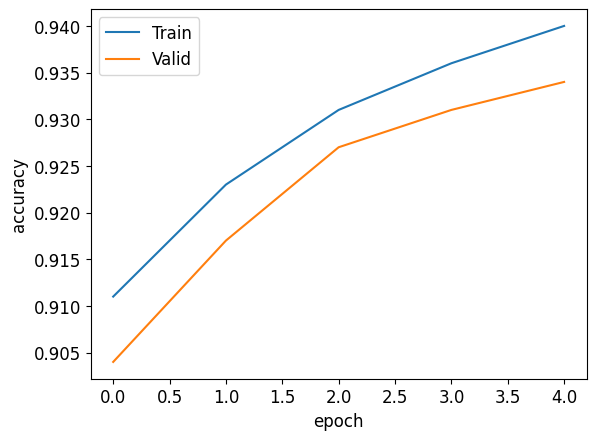

In [245]:
import matplotlib.pyplot as plt

plt.plot(range(epoch),[i[0] for i in history_accuracy], label='Train')
plt.plot(range(epoch),[i[1] for i in history_accuracy], label='Valid')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

**As can be seen** we have used quite a huge learning rate to achieve the fit. Normally we would use a learning rate of e.g. 0.003 to start with. But this learnign rate is too small for this instance.

Good thing to play around for the start would be exactly grabbing the learning rate & batch size and just trying extremes and seeing if the loss/metric improves

What we can notice as well is that the Validation converged in around the 2nd epoch, but training further caused the model to become more tightly knit with the Train set (Overfitting).
To some extent this is always acceptable, if we still gain Generic enough model even for data that it has never seen. *Lets keep in mind that the validation data we have seen over and over again and have used it to tweak the model.*

## Implement using fastAI

**At this point** we have a running model. So we should consider improving some parts.

E.g. instead of defining the parameters ourselves, we could define a Linear model from pytorch, which would do basically the same thing.

Also we are missing an Optimizer. Which in short means, the class that will calculate the prediction, and also clean up the calculated gradients.

In [265]:
# We cant change the view over the parameters, as that would remove the requires_gradient_calculation values and breaks us

simple_model = nn.Linear(28*28, 1)
dls = DataLoaders(train_dl, valid_dl)

learner = Learner(dls=dls, model=simple_model, opt_func=SGD, loss_func = sgd_loss, metrics = get_accuracy)
learner.fit(10, lr=0.03)

epoch,train_loss,valid_loss,get_accuracy,time
0,0.266448,0.178943,0.962218,00:02
1,0.176438,0.121763,0.964181,00:03
2,0.131201,0.099138,0.965653,00:02
3,0.105919,0.086767,0.966143,00:02
4,0.090568,0.078687,0.966143,00:02
5,0.080988,0.072960,0.967615,00:02
6,0.074211,0.068614,0.967125,00:02
7,0.068779,0.065222,0.968106,00:02
8,0.065211,0.062452,0.968106,00:02
9,0.061680,0.060114,0.969087,00:02


Now that we have run a normal model. Lets try a deeper one, with multiple layers and see how it improves

In [264]:
deeper_model = nn.Sequential(
    nn.Linear(28*28,60),
    nn.ReLU(),
    nn.Linear(60,20),
    nn.ReLU(),
    nn.Linear(20,1)
)

learner = Learner(dls=dls, model=deeper_model, opt_func=SGD, loss_func=sgd_loss, metrics=get_accuracy)
learner.fit(10, 0.03)

epoch,train_loss,valid_loss,get_accuracy,time
0,0.490421,0.482615,0.844946,00:03
1,0.462843,0.419122,0.928361,00:03
2,0.380676,0.262428,0.957802,00:03
3,0.248870,0.122787,0.966143,00:03
4,0.150742,0.076541,0.966634,00:03
5,0.097456,0.059843,0.967125,00:03
6,0.069920,0.051410,0.969578,00:04
7,0.055421,0.046311,0.970559,00:04
8,0.046909,0.042973,0.970069,00:03
9,0.041521,0.040435,0.971050,00:03


**What we can observe is** that we require a higher learning rate for more complex net to converge faster. At the same level `0.001` for simple Linear net & complex Sequential net, the Sequential did not converge at all in 5 epochs. Although we can see that the Sequential net might be able to capture deeper relationships. (At the same rate 0.03 the deeper net gets to higher accuracy faster than the smaller net).

So for getting a base understanding and baseline numbers the simpler model is better (also it trains faster), but for longer run we might rather want to use the deeper net (not neccessarily bigger, the matrix might be small, just with more layers)